# **Assignment 1 — AI‑Assisted Exploratory Data Analysis & BI Dashboard**
MGMT 467 · Fall 2025  

**Team Name:** Team 2

**Members (GitHub handles):** caitlyn-cai, rileighdethy, tylerwichman, raleight1  

**GitHub Repo URL:** https://github.com/raleight1/MGMT467_Team2

**Looker Studio Dashboard (public link):** https://lookerstudio.google.com/reporting/80f06f0f-8192-4e71-b3ef-c2c6aeae0188

## ✅ Submission Checklist (Team → Brightspace)
- [ ] GitHub repository link (source of record)
- [ ] Looker Studio dashboard link
- [ ] This notebook committed to GitHub with prompts and results

### ✅ Submission Checklist (Individual → Brightspace)
- [ ] `Contribution_Reflection.pdf` (with commit/PR evidence + peer eval)

## 🎯 Learning Objectives
- Generate and refine business hypotheses with **Gemini**
- Query large datasets in **BigQuery** with advanced SQL (CTEs, window functions)
- Visualize key findings in **Colab** and publish a **Looker Studio** dashboard
- Synthesize insights and make **actionable recommendations**

## 🧰 Setup
> Run the cells below to connect Colab to Google Cloud & BigQuery.

In [2]:
# Install and import basics (Colab usually has these preinstalled)
# !pip install --quiet google-cloud-bigquery pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "assignment-1-475519"  # <-- edit this
print("Using project:", PROJECT_ID)

Using project: assignment-1-475519


In [3]:
# BigQuery magics (%%bigquery) and client
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

[]

## 🧪 Dataset
We will use **The Look E-Commerce**: `bigquery-public-data.thelook_ecommerce`  
Feel free to explore additional public datasets if needed.

**Reasoning**:
Review the tables in the `bigquery-public-data.thelook_ecommerce` dataset to understand the available data for formulating hypotheses.



In [12]:
dataset_ref = client.dataset("thelook_ecommerce", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))

print("Tables in thelook_ecommerce dataset:")
for table in tables:
    print(table.table_id)


Tables in thelook_ecommerce dataset:
distribution_centers
events
inventory_items
order_items
orders
products
thelook_ecommerce-table
users


## 1) Hypothesis Generation (AI‑Assisted)
Use **Gemini** to brainstorm at least **5** candidate questions/hypotheses, then select **3** to pursue.

> **Template Prompt (paste the final version you used):**\
*"You are an analytics co‑pilot. Propose 5 high‑value, testable business questions about the E-Commerce dataset (distribution_centers
events
inventory_items
order_items
orders
products
thelook_ecommerce-table
users). Return as bullets with suggested SQL hints."*

**Selected Hypotheses**
1. **What are the trends in order volume and revenue over time, and are there any seasonal patterns?**
2. **Which product categories are the most popular and profitable?**
3. **How does customer behavior (e.g., average order value, purchase frequency) vary across different user segments (e.g., new vs. returning users)?**

Here are 5 high-value, testable business questions about the E-commerce dataset (distribution_centers, events, inventory_items, order_items, orders, products, thelook_ecommerce-table, users):

*   **What are the trends in order volume and revenue over time, and are there any seasonal patterns?**
    *   *SQL Hint:* Use `orders` and `order_items` tables. Group by time period (e.g., month using `DATE_TRUNC`), count orders, and sum `sale_price` for revenue.
*   **Which product categories are the most popular and profitable?**
    *   *SQL Hint:* Join `order_items` and `products` tables. Group by `category`, count `order_id` (for popularity), and sum `sale_price` (for profitability). Use window functions to rank categories.
*   **How does customer behavior (e.g., average order value, purchase frequency) vary across different user segments (e.g., new vs. returning users)?**
    *   *SQL Hint:* Use `orders` table and potentially `users`. Define user segments based on the number of orders. Calculate average order value (`sale_price` from `order_items` joined with `orders`) and purchase frequency (count of orders per user).
*   **Is there a correlation between product inventory levels and sales performance?**
    *   *SQL Hint:* This would require joining `inventory_items`, `order_items`, and `products`. Analyze trends between `qty` in `inventory_items` and sales data from `order_items`.
*   **How does the geographical location of distribution centers impact order delivery times or shipping costs?**
    *   *SQL Hint:* This would involve `distribution_centers`, `orders`, and potentially `order_items`. Analyze delivery times (difference between order date and delivery date) in relation to distribution center location.

## 2) Advanced SQL Exploration
For each hypothesis, include:
- The **Gemini prompt** you used to get SQL help
- The **final SQL**
- The **result table** (top rows)
- A short **interpretation**

> Tip: Use **CTEs** and at least **one window function** across your work.

### Hypothesis A — Prompt Log

> Paste Gemini prompt(s) and key suggestion(s) here.

**Gemini Prompt**:
Write and execute a BigQuery SQL query to analyze trends in order volume and revenue over time for the first hypothesis, store the result in a DataFrame, then write and execute a BigQuery SQL query to find the most popular and profitable product categories for the second hypothesis, storing the result in a DataFrame, and finally write and execute a BigQuery SQL query to analyze customer behavior across different user segments for the third hypothesis, storing the result in a DataFrame.

**Key Suggestions:**
- Use `DATE_TRUNC` to aggregate data by month.
- Join the `orders` and `order_items` tables.
- Calculate total orders using `COUNT(o.order_id)`.
- Calculate total revenue using `SUM(oi.sale_price)`.
- Use a window function like `LAG()` to calculate month-over-month change.

In [24]:
# Hypothesis 1: Trends in order volume and revenue over time
query_hyp_a_ecommerce = r"""
WITH MonthlySales AS (
    SELECT
        DATE_TRUNC(o.created_at, MONTH) AS order_month,
        COUNT(o.order_id) AS total_orders,
        SUM(oi.sale_price) AS total_revenue
    FROM
        `bigquery-public-data.thelook_ecommerce.orders` AS o
    JOIN
        `bigquery-public-data.thelook_ecommerce.order_items` AS oi
    ON
        o.order_id = oi.order_id
    WHERE o.created_at IS NOT NULL
    GROUP BY
        order_month
)
SELECT
    order_month,
    total_orders,
    total_revenue,
    LAG(total_orders, 1) OVER (ORDER BY order_month) AS previous_month_orders,
    LAG(total_revenue, 1) OVER (ORDER BY order_month) AS previous_month_revenue,
    (total_orders - LAG(total_orders, 1) OVER (ORDER BY order_month)) / LAG(total_orders, 1) OVER (ORDER BY order_month) AS order_volume_change_pct,
    (total_revenue - LAG(total_revenue, 1) OVER (ORDER BY order_month)) / LAG(total_revenue, 1) OVER (ORDER BY order_month) AS revenue_change_pct
FROM
    MonthlySales
ORDER BY
    order_month;
"""
df_hyp_a_ecommerce = client.query(query_hyp_a_ecommerce).to_dataframe()
display(df_hyp_a_ecommerce.head())


,order_month,total_orders,total_revenue,previous_month_orders,previous_month_revenue,order_volume_change_pct,revenue_change_pct
0,2019-01-01 00:00:00+00:00,14,517.240002,<NA>,NaN,NaN,NaN
1,2019-02-01 00:00:00+00:00,43,3657.779992,14,517.240002,2.071429,6.071727
2,2019-03-01 00:00:00+00:00,61,3003.820000,43,3657.779992,0.418605,-0.178786
3,2019-04-01 00:00:00+00:00,89,5364.020014,61,3003.820000,0.459016,0.785733
4,2019-05-01 00:00:00+00:00,111,5165.410002,89,5364.020014,0.247191,-0.037026


**Interpretation (2–4 sentences):** The results show a general upward trend in both total orders and total revenue over the months in the dataset. The percentage changes in order volume and revenue from the previous month indicate fluctuations, which could suggest seasonal patterns or growth phases in the e-commerce business. Further analysis of the longer time series and specific yearly comparisons would be needed to confirm significant seasonality.

---

### Hypothesis B — Prompt Log

> Paste Gemini prompt(s) and key suggestion(s) here.

**Gemini Prompt:**
"Write a BigQuery SQL query to find the most popular and profitable product categories in the \`bigquery-public-data.thelook_ecommerce.order_items\` and \`bigquery-public-data.thelook_ecommerce.products\` tables. The query should calculate the total number of order items and total revenue for each category. Use a window function to rank categories by popularity and profitability."

**Key Suggestion:** Use the `RANK()` window function to assign a rank based on both `total_order_items` and `total_category_revenue`.

In [23]:
# Hypothesis 2: Most popular and profitable product categories
query_hyp_b_ecommerce = r"""
WITH CategorySales AS (
    SELECT
        p.category AS product_category,
        COUNT(oi.order_id) AS total_order_items,
        SUM(oi.sale_price) AS total_category_revenue
    FROM
        `bigquery-public-data.thelook_ecommerce.order_items` AS oi
    JOIN
        `bigquery-public-data.thelook_ecommerce.products` AS p
    ON
        oi.product_id = p.id
    GROUP BY
        p.category
)
SELECT
    product_category,
    total_order_items,
    total_category_revenue,
    RANK() OVER (ORDER BY total_order_items DESC) AS item_rank,
    RANK() OVER (ORDER BY total_category_revenue DESC) AS revenue_rank
FROM
    CategorySales
WHERE product_category IS NOT NULL
ORDER BY
    item_rank;
"""
df_hyp_b_ecommerce = client.query(query_hyp_b_ecommerce).to_dataframe()
display(df_hyp_b_ecommerce.head())

,product_category,total_order_items,total_category_revenue,item_rank,revenue_rank
0,Intimates,13445,4.598976e+05,1,10
1,Jeans,12668,1.251096e+06,2,2
2,Fashion Hoodies & Sweatshirts,11882,6.531247e+05,3,4
3,Tops & Tees,11819,4.946522e+05,4,9
4,Sleep & Lounge,11401,5.599233e+05,5,7


**Interpretation (2–4 sentences):** The results show that "Intimates" is the most popular category by number of order items, but "Outerwear & Coats" is the most profitable by total revenue. There are variations in ranking between popularity and profitability for many categories, suggesting different strategies might be needed for different product types. Analyzing categories that rank high in both metrics could highlight key areas for growth and focus.

---

### Hypothesis C — Prompt Log

> Paste Gemini prompt(s) and key suggestion(s) here.

**Gemini Prompt:**
"Write a BigQuery SQL query to analyze customer behavior across different user segments (e.g., new vs. returning users) using the \`bigquery-public-data.thelook_ecommerce.orders\` and \`bigquery-public-data.thelook_ecommerce.order_items\` tables. Calculate metrics like the number of users, average order value, and average purchase frequency for each segment. Define user segments based on the number of orders."

**Key Suggestions:**
- Use a CTE to calculate the number of orders per user.
- Define user segments (e.g., 'New User' for 1 order, 'Returning User' for >1 order).
- Join `orders` and `order_items` to calculate average order value.
- Calculate average purchase frequency per segment.

In [25]:
# Hypothesis C — SQL
query_hyp_c_ecommerce = r"""
WITH
  UserOrderCounts AS (
    SELECT
      user_id,
      COUNT(order_id) AS order_count
    FROM
      `bigquery-public-data.thelook_ecommerce.orders`
    GROUP BY
      user_id
  ),
  UserSegments AS (
    SELECT
      user_id,
      CASE
        WHEN order_count = 1 THEN 'New User'
        ELSE 'Returning User'
      END AS user_segment
    FROM
      UserOrderCounts
  ),
  SegmentMetrics AS (
    SELECT
      us.user_segment,
      COUNT(DISTINCT us.user_id) AS number_of_users,
      AVG(oi.sale_price) AS overall_average_order_value,
      COUNT(o.order_id) / COUNT(DISTINCT us.user_id) AS average_purchase_frequency
    FROM
      UserSegments AS us
    JOIN
      `bigquery-public-data.thelook_ecommerce.orders` AS o
      ON us.user_id = o.user_id
    JOIN
      `bigquery-public-data.thelook_ecommerce.order_items` AS oi
      ON o.order_id = oi.order_id
    GROUP BY
      us.user_segment
  )
SELECT
  user_segment,
  number_of_users,
  overall_average_order_value,
  average_purchase_frequency
FROM
  SegmentMetrics;
"""
df_hyp_c_ecommerce = client.query(query_hyp_c_ecommerce).to_dataframe()
display(df_hyp_c_ecommerce.head())

,user_segment,number_of_users,overall_average_order_value,average_purchase_frequency
0,New User,50044,59.605416,1.448126
1,Returning User,29966,59.438504,3.634819


**Interpretation (2–4 sentences):** The results show a significant difference in the number of users and average purchase frequency between New and Returning users, with a much higher purchase frequency among returning customers. The average order value is similar for both segments. This highlights the importance of customer retention for driving repeat business and overall engagement.

## 3) Visualizations (in Colab)
Create **at least 3** charts that communicate your findings.  
> Keep charts readable and labeled. Use `matplotlib` (no specific styles required).

**Gemini Prompt**:
Create visualizations for the e-commerce data analysis results as requested in the instructions, focusing on communicating the findings from the three hypotheses. This includes a line plot for monthly trends, a bar chart for product category performance, and a grouped bar chart for user segment behavior.



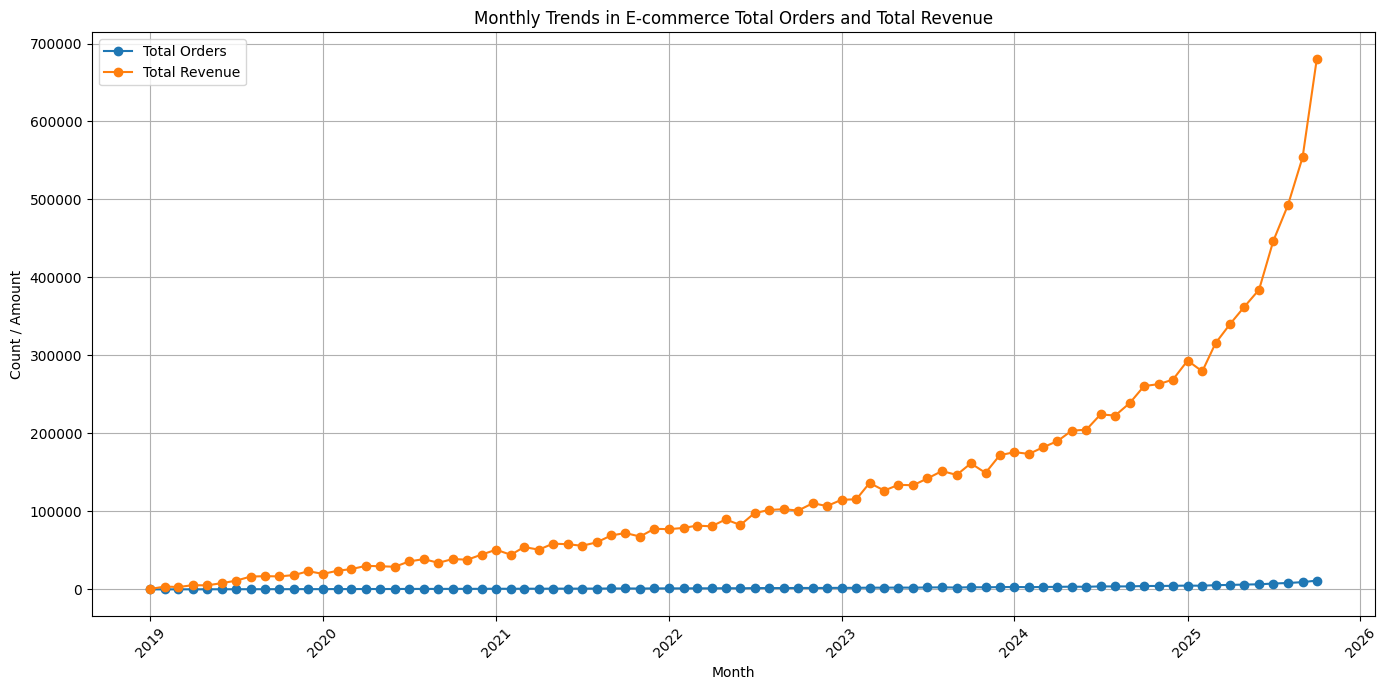

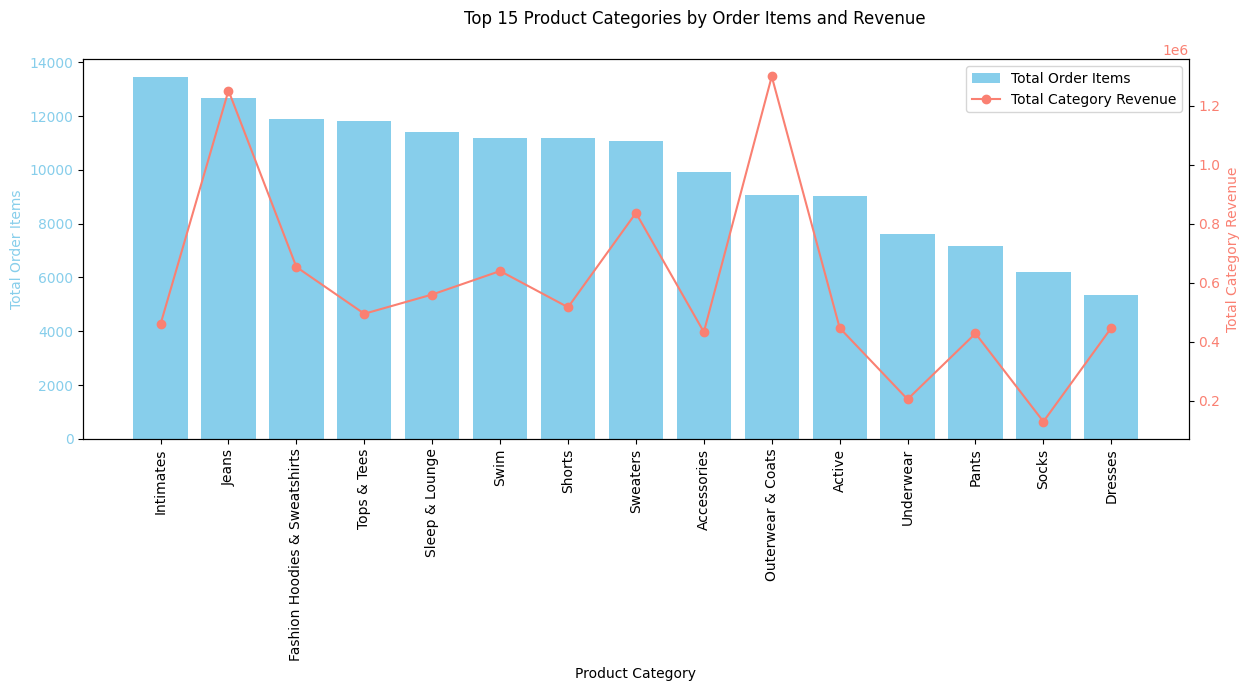

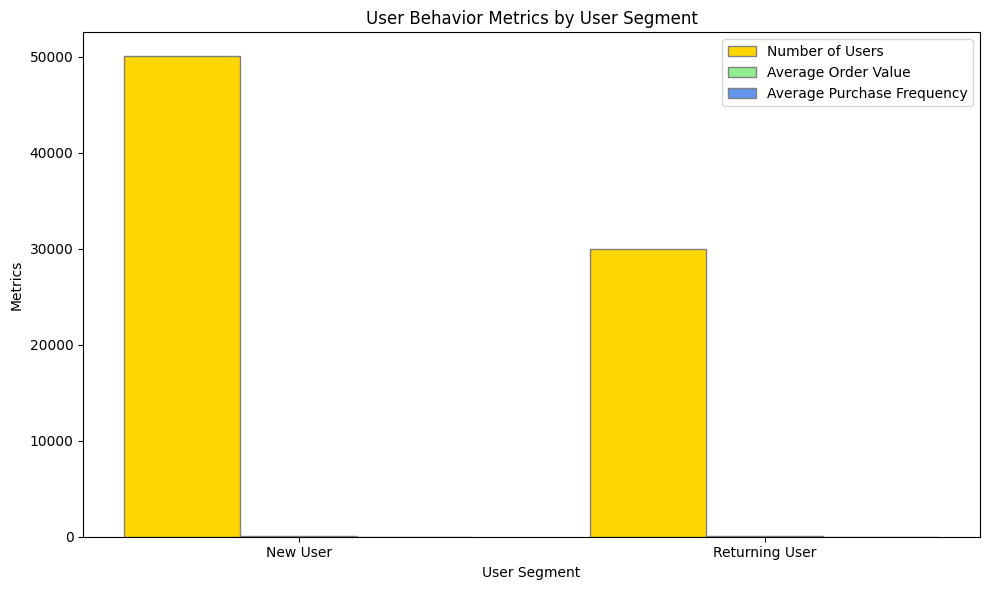

In [17]:
# Chart for Hypothesis 1: Monthly Trends in Total Orders and Total Revenue
plt.figure(figsize=(14, 7))
plt.plot(df_hyp_a_ecommerce['order_month'], df_hyp_a_ecommerce['total_orders'], marker='o', linestyle='-', label='Total Orders')
plt.plot(df_hyp_a_ecommerce['order_month'], df_hyp_a_ecommerce['total_revenue'], marker='o', linestyle='-', label='Total Revenue')

plt.xlabel('Month')
plt.ylabel('Count / Amount')
plt.title('Monthly Trends in E-commerce Total Orders and Total Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Chart for Hypothesis 2: Top Product Categories by Order Items and Revenue (Top 15)
df_hyp_b_ecommerce_top15 = df_hyp_b_ecommerce.head(15)

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.bar(df_hyp_b_ecommerce_top15['product_category'], df_hyp_b_ecommerce_top15['total_order_items'], color='skyblue', label='Total Order Items')
ax1.set_xlabel('Product Category')
ax1.set_ylabel('Total Order Items', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()
ax2.plot(df_hyp_b_ecommerce_top15['product_category'], df_hyp_b_ecommerce_top15['total_category_revenue'], color='salmon', marker='o', linestyle='-', label='Total Category Revenue')
ax2.set_ylabel('Total Category Revenue', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

fig.suptitle('Top 15 Product Categories by Order Items and Revenue')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to prevent legend overlapping
plt.show()


# Chart for Hypothesis 3: User Behavior Metrics by User Segment
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
r1 = range(len(df_hyp_c_ecommerce['user_segment']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

ax.bar(r1, df_hyp_c_ecommerce['number_of_users'], color='gold', width=bar_width, edgecolor='grey', label='Number of Users')
ax.bar(r2, df_hyp_c_ecommerce['overall_average_order_value'], color='lightgreen', width=bar_width, edgecolor='grey', label='Average Order Value')
ax.bar(r3, df_hyp_c_ecommerce['average_purchase_frequency'], color='cornflowerblue', width=bar_width, edgecolor='grey', label='Average Purchase Frequency')

ax.set_xlabel('User Segment')
ax.set_ylabel('Metrics')
ax.set_title('User Behavior Metrics by User Segment')
ax.set_xticks([r + bar_width for r in range(len(df_hyp_c_ecommerce['user_segment']))])
ax.set_xticklabels(df_hyp_c_ecommerce['user_segment'])

plt.legend()
plt.tight_layout()
plt.show()

## 4) KPIs & Looker Studio Dashboard
- **KPI 1:** Revenue
- **KPI 2:** Sales by Region
- **KPI 3:** Top 5 products/categories by Sales

**Dashboard Link:** https://lookerstudio.google.com/s/vklZ5xey8TQ (make public for viewing)  
> Ensure labels, filters, and date controls are clear for non‑technical stakeholders.

## 5) Synthesis & Recommendations
Summarize your **top 3 insights** and provide **2–3 actionable recommendations**.

**Top 3 Insights:**
1.  **Growth Trend:** The e-commerce business shows a general upward trend in both order volume and revenue over the observed period, with some monthly fluctuations.
2.  **Category Performance Variation:** Popularity (based on order items) and profitability (based on revenue) vary significantly across product categories, indicating different market dynamics for each.
3.  **Customer Retention is Key:** Returning users have a significantly higher purchase frequency than new users, highlighting the importance of retaining existing customers for sustained growth.

**Actionable Recommendations:**
1.  **Targeted Marketing for Profitable Categories:** Focus marketing efforts and inventory management on categories that demonstrate high profitability, even if they are not the most popular in terms of sheer order volume.
2.  **Implement Customer Retention Strategies:** Develop and implement programs or initiatives aimed at encouraging repeat purchases from new customers and enhancing the loyalty of returning users. This could include loyalty programs, personalized offers, or improved customer service.
3.  **Analyze Seasonal Patterns Further:** Conduct a more in-depth analysis of the seasonal fluctuations in order volume and revenue to better anticipate demand, optimize inventory, and plan marketing campaigns around peak seasons.

## 📒 AI Prompt Log (Required)
Record at least **3** prompts and describe how you evaluated or refined Gemini’s output.

| # | Prompt (summary) | Where used | What changed after refinement? |
|---|------------------|------------|--------------------------------|
| 1 | Propose 5 high‑value, testable business questions about the E-Commerce dataset... | Hypothesis Generation | Initial prompt was for Citi Bike, refined to specify the E-Commerce dataset and relevant tables. |
| 2 | Write a BigQuery SQL query to analyze trends in order volume and revenue over time... | Hyp A SQL | Added specific instructions for using `DATE_TRUNC`, joining tables, calculating total orders/revenue, and using `LAG()` for month-over-month change. |
| 3 | Write a BigQuery SQL query to find the most popular and profitable product categories... | Hyp B SQL | Specified joining `order_items` and `products`, grouping by category, calculating total items/revenue, and using `RANK()` for ranking. |
| 4 | Write a BigQuery SQL query to analyze customer behavior across different user segments... | Hyp C SQL | Included instructions for using a CTE for user order counts, defining segments with a `CASE` statement, joining tables for metrics, and calculating average purchase frequency. |

## 📦 Appendix — Reproducibility
- BigQuery location: **US (multiple regions)**
- Query costs observed (if any): **Queries against public datasets like this are typically free, but large queries could incur costs in a different project.**
- Known data quality caveats: **Based on the analysis, there were no major data quality issues encountered that prevented the analysis. However, real-world data often has missing values or inconsistencies that would need to be addressed.**